C:\Users\yashy\AppData\Local\Temp\ipykernel_15828\537598306.py:23: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


Summary of Metrics:
            Port_IDs            ROI           PnL  Sharpe_Ratio    Win_Rate  \
count  1.500000e+02     150.000000    150.000000    150.000000  150.000000   
mean   3.975655e+18   19852.183512   4606.991038      0.184527    0.370535   
std    6.887470e+16   97935.653932   7747.263831      0.134644    0.150895   
min    3.672755e+18    -891.935587 -12346.682219     -0.077929    0.000000   
25%    3.943672e+18       0.000000   1753.432624      0.089662    0.281878   
50%    3.998616e+18     987.311720   2683.547936      0.163682    0.378145   
75%    4.029508e+18    3836.050266   4725.862074      0.260054    0.465198   
max    4.041860e+18  989179.455314  71998.855953      0.675101    0.802612   

       Total_Positions         MDD  
count       150.000000  150.000000  
mean       1408.520000   -3.829524  
std        1876.051332   14.435188  
min           1.000000 -173.433771  
25%         154.750000   -2.613585  
50%         528.000000   -1.340551  
75%        1706.7

C:\Users\yashy\AppData\Local\Temp\ipykernel_15828\537598306.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Port_IDs', y='Score', data=metrics, palette='viridis')


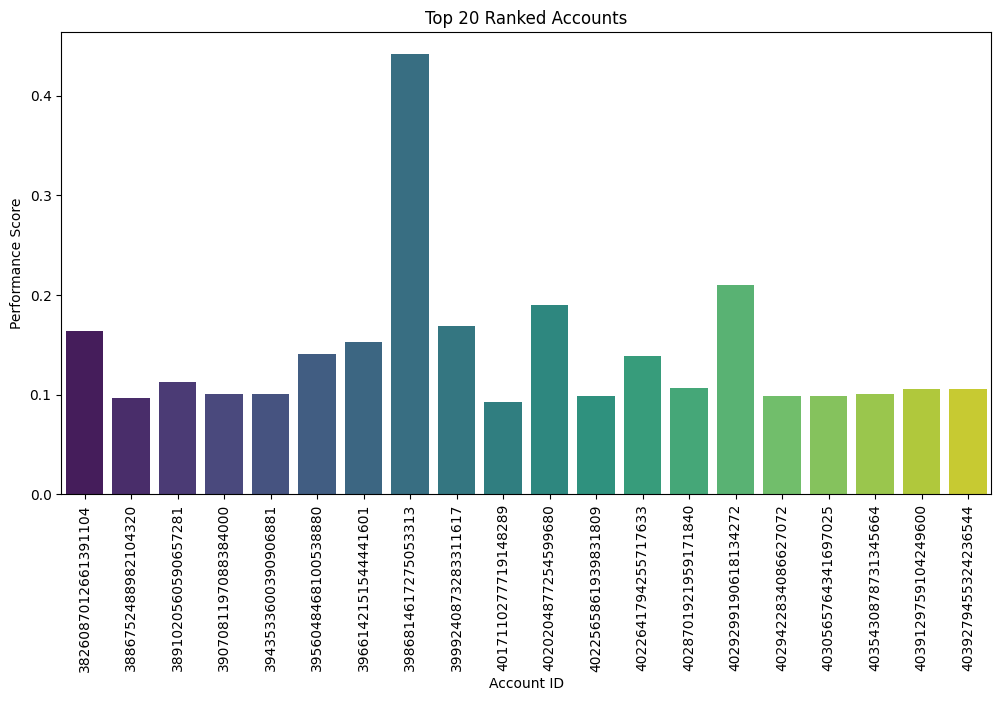

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

def flatten_data(filepath):
    df = pd.read_csv(filepath)
    df['Trade_History'] = df['Trade_History'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df = df.reset_index(drop=True)
    df_expanded = df.explode('Trade_History')
    df_trades = pd.json_normalize(df_expanded['Trade_History'])
    df_final = pd.concat([df_expanded[['Port_IDs']].reset_index(drop=True), df_trades], axis=1)
    df_final['timestamp'] = pd.to_datetime(df_final['time'], unit='ms')
    df_final.rename(columns={'symbol': 'asset'}, inplace=True)
    df_final = df_final.loc[:, ~df_final.columns.duplicated()]
    df_final.to_csv("cleaned_trade_data.csv", index=False)
    return "cleaned_trade_data.csv"


def load_data(filepath):
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


def feature_engineering(df):
    df['position_type'] = df['side'] + '_' + df['positionSide']
    df['win_position'] = df['realizedProfit'] > 0
    return df


def max_drawdown(profit_series):
    if profit_series.empty or (profit_series <= 0).all():
        return 0  #No meaningful drawdown if values are 0 or negative

    running_max = profit_series.cummax()
    drawdown = (profit_series - running_max) / running_max
    return drawdown.min() if not drawdown.isna().all() else 0  # Avoid NaN values

# Financial Metrics Calculation
def calculate_metrics(df):
    grouped = df.groupby('Port_IDs')

    metrics = grouped.agg(
        ROI=('realizedProfit', lambda x: (x.sum() / abs(x.min())) * 100 if x.min() != 0 else 0),
        PnL=('realizedProfit', 'sum'),
        Sharpe_Ratio=('realizedProfit', lambda x: x.mean() / x.std() if x.std() != 0 else 0),
        Win_Rate=('win_position', 'mean'),
        Total_Positions=('Port_IDs', 'count')
    ).reset_index()

    metrics['MDD'] = grouped['realizedProfit'].apply(max_drawdown).reset_index(drop=True)

    # Replace infinite values with NaN and fill NaN with 0
    metrics.replace([np.inf, -np.inf], np.nan, inplace=True)
    metrics.fillna(0, inplace=True)

    return metrics

# Ranking Algorithm
def rank_accounts(metrics):
    weights = {
        'ROI': 0.3,
        'PnL': 0.25,
        'Sharpe_Ratio': 0.2,
        'MDD': -0.15,  # Negative weight 
        'Win_Rate': 0.1
    }

    # Normalize each metric
    for metric in weights.keys():
        min_val, max_val = metrics[metric].min(), metrics[metric].max()
        if max_val != min_val:
            metrics[metric] = (metrics[metric] - min_val) / (max_val - min_val)
        else:
            metrics[metric] = 0  # Avoid division by zero if all values are identical

    #final weighted Score
    metrics['Score'] = sum(metrics[metric] * weight for metric, weight in weights.items())

    #Sort and return top 20 accounts
    return metrics.sort_values(by='Score', ascending=False).head(20)

def save_results(metrics, filename='top_20_accounts.csv'):
    metrics.to_csv(filename, index=False)

def visualize_metrics(metrics):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Port_IDs', y='Score', data=metrics, palette='viridis')
    plt.xticks(rotation=90)
    plt.title('Top 20 Ranked Accounts')
    plt.xlabel('Account ID')
    plt.ylabel('Performance Score')
    plt.show()




In [ ]:
#main exwcution
filepath = r"trade_data.csv"  # Update with actual file path
cleaned_filepath = flatten_data(filepath)

df = load_data(cleaned_filepath)
df = feature_engineering(df)
metrics = calculate_metrics(df)

print("Summary of Metrics:\n", metrics.describe())  # Debugging step
print("Checking NaN counts:\n", metrics.isna().sum())  # Debugging step

top_20 = rank_accounts(metrics)

print("Top 20 Accounts with Scores:\n", top_20[['Port_IDs', 'Score']])  # Debugging step

save_results(top_20)
visualize_metrics(top_20)